# NST on Images using vgg16 network*

    Kuldeep Singh
    Roll # - 16235
    Department - Physics
    BSMS 2016 Batch

## Basic NST

### Importing Packages

In [1]:
from __future__ import print_function
from PIL import Image
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#ls -l #confirming directory and its content

total 4
---------- 1 root root 263 Dec 16 04:31 __notebook_source__.ipynb


In [4]:
#cd ../input/style-transfer-testing #While working on kaggle notebook, this code is required to get input files.

/kaggle/input/style-transfer-testing


### Importing Style and Content Image

In [8]:
art = "images/dotted.jpg"
content = "images/nimtin.jpg"
style = Image.open(art)
style_shape = style.size
style_shape  # this shape will be used for our stylized output also

(600, 749)

In [9]:
# image = Image.open(content)
# plt.figure()
# imshow(image)

**Loading Image as tensor**

Using Image loader function i had asserted the shape of style and content image to be same

In [31]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    p = transforms.Compose([transforms.Resize((style_shape[1],style_shape[0])),
                            transforms.ToTensor()])
    print(image.size)
    image = p(image).unsqueeze(0)
    print(f'{image.shape} is the shape of image {image_name}')
    return image.to(device, torch.float)



style_img = image_loader(art)
content_img = image_loader(content)

(600, 749)
torch.Size([1, 3, 749, 600]) is the shape of image dotted.jpg
(4608, 3456)
torch.Size([1, 3, 749, 600]) is the shape of image nimtin.jpg


**Unloader function is used to convert tensor back to image**

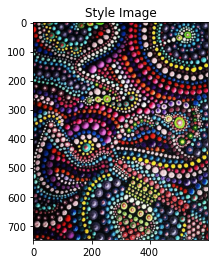

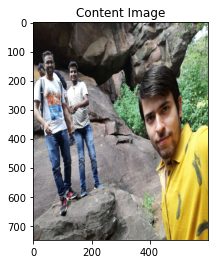

In [32]:
unloader = transforms.ToPILImage()  # reconvert into PIL image, as we need to visualize our imagew

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

> ## Loss Functions

### Content Loss

In [33]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

In [34]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
                               # b=number of feature maps
                               # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # 'normalized' the values of the gram matrix.
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [35]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing VGG16 Model

In [36]:
cnn = models.vgg16(pretrained=True).features.to(device).eval()

In [37]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

layers to be modified and function for losses is defined.

In [38]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['caonv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### Gradient Descent

In [40]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()]) #Limited memory Broyden–Fletcher–Goldfarb–Shanno algorithm
    return optimizer

### Run the Model

num_steps value is subject to the result obtained during training. Some images require more than 2000 steps.

In [41]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                plt.figure()
                imshow(input_img, title='Input Image')
                plt.ioff()
                #plt.savefig(input_img, dpi=300)
                plt.show()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    
    # saving output image after all runs.
    save_image(input_img, f'/kaggle/working/{art[:4]}_{content[:3]}_{str(num_steps)}.jpg')
    return input_img

Building the style transfer model..
Optimizing..


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [100]:
Style Loss : 783.184753 Content Loss: 63.898594



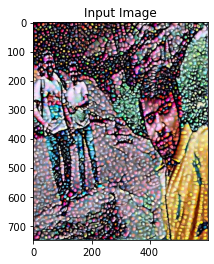

run [200]:
Style Loss : 95.424210 Content Loss: 69.848969



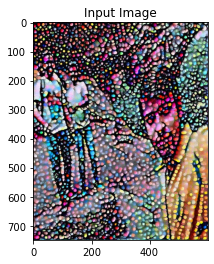

run [300]:
Style Loss : 55.844402 Content Loss: 68.942406



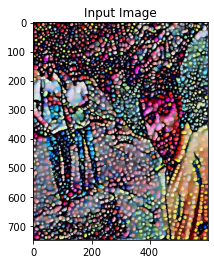

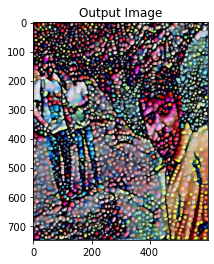

In [42]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# # sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.savefig('nimtin_output', dpi=300)
plt.show()

In [43]:
#save_image(output, '/kaggle/working/name_nim.jpg')

## Future

*Reason for not completing rest of the part -- I was assuming that I would be allowed to return to college after my urgent home visit, But it turned out to be opposite of that. All above written code is everything i had done before 7th of December.

Above code is the most basic implementation of NST. [MSG-Net](http://computervisionrutgers.github.io/MSG-Net/) will be used to further capture and embedd the features from style to our content image. With this implementation we can achieve transfer rate of around 15fps on decent gpu enabled pc or google colab.(kaggle is faster though)